In [5]:
import sys
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import torch.utils.data.dataloader as Data
import os
import time
from torch.autograd import Variable
from DAST_utils import *
from DAST_Network import *
from torch.utils.data import TensorDataset,DataLoader
from tqdm import tqdm

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [7]:
#Myscore function
def myScore(Target, Pred):
    tmp1 = 0
    tmp2 = 0
    for i in range(len(Target)):
        if Target[i] > Pred[i]:
            tmp1 = tmp1 + math.exp((-Pred[i] + Target[i]) / 13.0) - 1
        else:
            tmp2 = tmp2 + math.exp((Pred[i] - Target[i]) / 10.0) - 1
    tmp = tmp1 + tmp2
    return tmp

In [8]:
prediction_loss = []
# Load preprocessed data
X_train = sio.loadmat('../../../data/cmapss/processed_data/F001_window_size_trainX.mat')  # load sliding window preprocessed and Statistical features processed data (mean value and regression coefficient estimates feature)
X_train = X_train['train1X']

# X_train = X_train.reshape(len(X_train),42,14)
Y_train = sio.loadmat('../../../data/cmapss/processed_data/F001_window_size_trainY.mat')
Y_train = Y_train['train1Y']
Y_train = Y_train.transpose()

X_test = sio.loadmat('../../../data/cmapss/processed_data/F001_window_size_testX.mat')
X_test = X_test['test1X']
# X_test = X_test.reshape(len(X_test),42,14)
Y_test = sio.loadmat('../../../data/cmapss/processed_data/F001_window_size_testY.mat')
Y_test = Y_test['test1Y']
Y_test = Y_test.transpose()

In [9]:
print(X_train.shape)
print(Y_train.shape)

(16731, 40, 17)
(16731, 1)


In [10]:
X_train = Variable(torch.Tensor(X_train).float())
Y_train = Variable(torch.Tensor(Y_train).float())
X_test = Variable(torch.Tensor(X_test).float())
Y_test = Variable(torch.Tensor(Y_test).float())

In [11]:
print(X_test.shape)
print(Y_test.shape)

torch.Size([100, 40, 17])
torch.Size([100, 1])


In [12]:
#Hyperparameters
batch_size = 256
dim_val = 32
dim_attn = 32
dim_val_t = 32
dim_attn_t = 32
dim_val_s = 32
dim_attn_s = 32
n_heads = 4
n_decoder_layers = 1
n_encoder_layers = 2
max_rul = 125
lr = 0.001
epochs = 50
time_step = 40
dec_seq_len = 4
output_sequence_length = 1
input_size = 17

In [13]:
#Dataloader
train_dataset = TensorDataset(X_train,Y_train)
train_loader = Data.DataLoader(dataset=train_dataset,batch_size = batch_size,shuffle=True)
test_dataset = TensorDataset(X_test,Y_test)
test_loader = Data.DataLoader(dataset=test_dataset,batch_size = batch_size,shuffle=False)

In [14]:
# print(train_dataset[0:1])
# print('=' * 60)
# # 循环取数据
# for x_train, y_label in train_dataset:
#     print(x_train, y_label)

In [15]:
# Initialize model parameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# debug = True
debug = False
model = DAST(dim_val_s,dim_attn_s,dim_val_t,dim_attn_t,dim_val, dim_attn,time_step,input_size,dec_seq_len,output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads, debug)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [16]:
# model._modules

In [17]:
print(next(model.parameters()).device)

cuda:0


In [18]:
# model.children()

In [19]:
#Training  and testing
loss_list = []
train_loss_list = []
test_loss_list = []
train_time = []
test_time = []
model_loss = 1000

In [20]:
for epoch in range(epochs):
    #training
    model.train()
    start1 = time.time()
    loop = tqdm(train_loader, leave=True)
    for i,(X, Y) in enumerate(loop):
        batch_X = X.to(device)
        batch_Y = Y.to(device)
        out = model(batch_X)
        # print(out[0])
        # print(out.next)
        loss = torch.sqrt(criterion(out*max_rul, batch_Y*max_rul))
        # print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    end1 = time.time()
    train_time.append(end1 - start1)
    loss_eopch = np.mean(np.array(loss_list))
    train_loss_list.append(loss_eopch)
    print('epoch = ',epoch,
            'train_loss = ',loss_eopch.item())

    #testing
    model.eval()
    prediction_list = []
    for j ,(batch_x,batch_y) in enumerate(test_loader):
        batch_X = batch_x.to(device)
        batch_Y = batch_y.to(device)
        start2= time.time()
        prediction = model(batch_X)
        end2 = time.time()
        test_time.append(end2 - start2)
        prediction[prediction<0] = 0
        prediction_list.append(prediction)

    out_batch_pre = torch.cat(prediction_list).detach().cpu().numpy()
    prediction_tensor = torch.from_numpy(out_batch_pre)
    test_loss = torch.sqrt(criterion(prediction_tensor*125, Y_test*125))
    test_loss_list.append(test_loss.item())
    Y_test_numpy = Y_test.detach().numpy()
    test_score = myScore(Y_test_numpy*125, out_batch_pre*125)
    print('test_loss = ', test_loss.item(),
            'test_score = ', test_score)
    

100%|██████████| 66/66 [00:03<00:00, 21.11it/s]


epoch =  0 train_loss =  25.802695216554582
test_loss =  20.85529899597168 test_score =  1324.2545442315513


100%|██████████| 66/66 [00:03<00:00, 20.26it/s]


epoch =  1 train_loss =  23.24405492435802
test_loss =  18.655019760131836 test_score =  946.9354351184878


100%|██████████| 66/66 [00:03<00:00, 20.68it/s]


epoch =  2 train_loss =  21.965232011043664
test_loss =  16.28493309020996 test_score =  647.4316441900136


100%|██████████| 66/66 [00:03<00:00, 20.36it/s]


epoch =  3 train_loss =  20.337074240048725
test_loss =  14.107802391052246 test_score =  336.4915679013726


100%|██████████| 66/66 [00:03<00:00, 21.12it/s]


epoch =  4 train_loss =  19.031241648124926
test_loss =  13.639843940734863 test_score =  417.7778333157939


100%|██████████| 66/66 [00:03<00:00, 20.98it/s]


epoch =  5 train_loss =  17.982229138865616
test_loss =  13.130605697631836 test_score =  343.97673517114345


100%|██████████| 66/66 [00:03<00:00, 20.39it/s]


epoch =  6 train_loss =  17.201167007545372
test_loss =  14.220561981201172 test_score =  517.8349471484327


100%|██████████| 66/66 [00:03<00:00, 21.38it/s]


epoch =  7 train_loss =  16.570638795693714
test_loss =  13.961799621582031 test_score =  465.2889492137796


100%|██████████| 66/66 [00:03<00:00, 21.71it/s]


epoch =  8 train_loss =  16.078750724342935
test_loss =  14.116427421569824 test_score =  528.8420990858139


100%|██████████| 66/66 [00:03<00:00, 20.95it/s]


epoch =  9 train_loss =  15.659169366142967
test_loss =  13.22073745727539 test_score =  342.54013301391825


100%|██████████| 66/66 [00:03<00:00, 20.63it/s]


epoch =  10 train_loss =  15.303458219060555
test_loss =  13.094822883605957 test_score =  363.04636354138876


100%|██████████| 66/66 [00:03<00:00, 20.84it/s]


epoch =  11 train_loss =  14.993063147621925
test_loss =  13.324699401855469 test_score =  358.06415007061514


100%|██████████| 66/66 [00:03<00:00, 20.24it/s]


epoch =  12 train_loss =  14.72942626281774
test_loss =  12.890624046325684 test_score =  318.58216835443983


100%|██████████| 66/66 [00:03<00:00, 20.32it/s]


epoch =  13 train_loss =  14.505135557868265
test_loss =  13.03713321685791 test_score =  373.43255083565464


100%|██████████| 66/66 [00:03<00:00, 19.98it/s]


epoch =  14 train_loss =  14.298330794440375
test_loss =  14.185235023498535 test_score =  542.5413278639851


100%|██████████| 66/66 [00:03<00:00, 20.70it/s]


epoch =  15 train_loss =  14.123413110321218
test_loss =  13.2127046585083 test_score =  337.90486164465267


100%|██████████| 66/66 [00:03<00:00, 21.24it/s]


epoch =  16 train_loss =  13.961421908754291
test_loss =  12.846172332763672 test_score =  356.6992760557598


100%|██████████| 66/66 [00:03<00:00, 20.42it/s]


epoch =  17 train_loss =  13.815175534097435
test_loss =  13.070481300354004 test_score =  393.71379257484404


100%|██████████| 66/66 [00:03<00:00, 21.20it/s]


epoch =  18 train_loss =  13.672908693979801
test_loss =  13.49547290802002 test_score =  284.7071345720676


100%|██████████| 66/66 [00:03<00:00, 20.54it/s]


epoch =  19 train_loss =  13.52701308221528
test_loss =  12.90298843383789 test_score =  275.35025202041516


100%|██████████| 66/66 [00:03<00:00, 20.39it/s]


epoch =  20 train_loss =  13.388571555480297
test_loss =  12.8564453125 test_score =  375.7648005048114


100%|██████████| 66/66 [00:03<00:00, 20.98it/s]


epoch =  21 train_loss =  13.260570700831979
test_loss =  12.869466781616211 test_score =  354.7719274053943


100%|██████████| 66/66 [00:03<00:00, 20.82it/s]


epoch =  22 train_loss =  13.140194731424605
test_loss =  12.362167358398438 test_score =  275.368185848904


100%|██████████| 66/66 [00:03<00:00, 21.20it/s]


epoch =  23 train_loss =  13.022537139329044
test_loss =  12.616427421569824 test_score =  290.843694657293


100%|██████████| 66/66 [00:03<00:00, 20.63it/s]


epoch =  24 train_loss =  12.919189057205662
test_loss =  12.192523002624512 test_score =  251.82128884462065


100%|██████████| 66/66 [00:03<00:00, 20.28it/s]


epoch =  25 train_loss =  12.805585747832184
test_loss =  12.825881004333496 test_score =  266.5488410817396


100%|██████████| 66/66 [00:03<00:00, 20.92it/s]


epoch =  26 train_loss =  12.706485026345643
test_loss =  12.173670768737793 test_score =  295.3133947569081


100%|██████████| 66/66 [00:03<00:00, 21.01it/s]


epoch =  27 train_loss =  12.60583874105891
test_loss =  12.275433540344238 test_score =  223.9893474060139


100%|██████████| 66/66 [00:03<00:00, 21.60it/s]


epoch =  28 train_loss =  12.513271074683688
test_loss =  12.936676979064941 test_score =  232.19349039713148


100%|██████████| 66/66 [00:03<00:00, 21.21it/s]


epoch =  29 train_loss =  12.429527700790251
test_loss =  12.368195533752441 test_score =  260.0131885750017


100%|██████████| 66/66 [00:03<00:00, 20.78it/s]


epoch =  30 train_loss =  12.34427091779364
test_loss =  12.402945518493652 test_score =  229.74861824121496


100%|██████████| 66/66 [00:03<00:00, 19.86it/s]


epoch =  31 train_loss =  12.261324402960865
test_loss =  13.289569854736328 test_score =  421.87127179528375


100%|██████████| 66/66 [00:03<00:00, 20.32it/s]


epoch =  32 train_loss =  12.18030206274833
test_loss =  12.89300537109375 test_score =  318.2891175199008


100%|██████████| 66/66 [00:03<00:00, 21.32it/s]


epoch =  33 train_loss =  12.095545689689922
test_loss =  12.880542755126953 test_score =  327.5230481127785


100%|██████████| 66/66 [00:03<00:00, 21.38it/s]


epoch =  34 train_loss =  12.01501820572527
test_loss =  13.646183013916016 test_score =  404.0068842538237


100%|██████████| 66/66 [00:03<00:00, 20.95it/s]


epoch =  35 train_loss =  11.936938606528722
test_loss =  12.702887535095215 test_score =  336.8194517898884


100%|██████████| 66/66 [00:03<00:00, 20.89it/s]


epoch =  36 train_loss =  11.861747019218676
test_loss =  12.680564880371094 test_score =  311.23270149080554


100%|██████████| 66/66 [00:03<00:00, 21.26it/s]


epoch =  37 train_loss =  11.79137432023859
test_loss =  13.024426460266113 test_score =  343.764495351502


100%|██████████| 66/66 [00:03<00:00, 20.74it/s]


epoch =  38 train_loss =  11.719619433640878
test_loss =  13.348190307617188 test_score =  365.442174657527


100%|██████████| 66/66 [00:03<00:00, 20.45it/s]


epoch =  39 train_loss =  11.654569160215782
test_loss =  13.16843318939209 test_score =  394.0045001926017


100%|██████████| 66/66 [00:03<00:00, 20.11it/s]


epoch =  40 train_loss =  11.59428090531123
test_loss =  14.651208877563477 test_score =  573.7417602593029


100%|██████████| 66/66 [00:03<00:00, 20.15it/s]


epoch =  41 train_loss =  11.526715139289955
test_loss =  13.843334197998047 test_score =  353.447335336939


100%|██████████| 66/66 [00:03<00:00, 20.21it/s]


epoch =  42 train_loss =  11.462554068864442
test_loss =  13.545635223388672 test_score =  367.3218004942009


100%|██████████| 66/66 [00:03<00:00, 20.24it/s]


epoch =  43 train_loss =  11.399994358379322
test_loss =  14.16793441772461 test_score =  421.79166079702424


100%|██████████| 66/66 [00:03<00:00, 21.00it/s]


epoch =  44 train_loss =  11.33336391882463
test_loss =  14.058334350585938 test_score =  369.4350514938135


100%|██████████| 66/66 [00:03<00:00, 20.44it/s]


epoch =  45 train_loss =  11.26715659184261
test_loss =  14.65606689453125 test_score =  391.67121015888455


100%|██████████| 66/66 [00:03<00:00, 20.59it/s]


epoch =  46 train_loss =  11.206538107224544
test_loss =  14.434322357177734 test_score =  374.2807038730149


100%|██████████| 66/66 [00:03<00:00, 20.59it/s]


epoch =  47 train_loss =  11.147886109322009
test_loss =  13.648530960083008 test_score =  366.15298321602285


100%|██████████| 66/66 [00:03<00:00, 20.69it/s]


epoch =  48 train_loss =  11.088682744999911
test_loss =  13.835107803344727 test_score =  420.6312265130747


100%|██████████| 66/66 [00:03<00:00, 21.13it/s]

epoch =  49 train_loss =  11.025780834284696
test_loss =  15.181461334228516 test_score =  632.5014546875751


In [23]:
z = np.reshape(out_batch_pre, (-1))
z = z.tolist()

In [24]:
y = Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

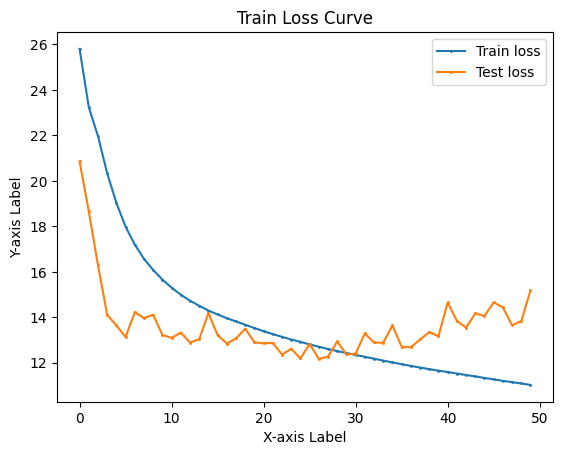

In [25]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(train_loss_list, label='Train loss', marker='o', markersize=1)
plt.plot(test_loss_list, label='Test loss', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Train Loss Curve')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

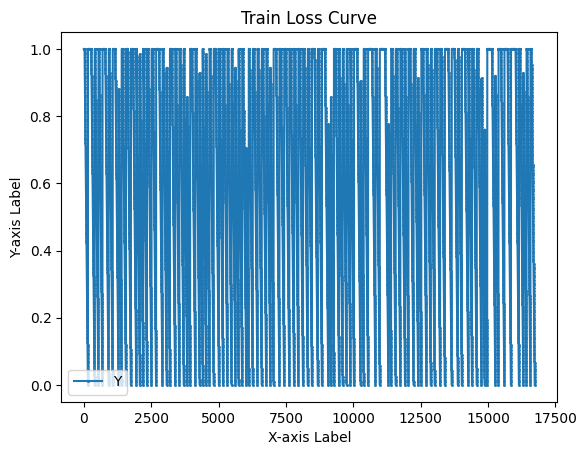

In [28]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
# plt.plot(X_train[0], label='Pred', marker='o', markersize=1)
plt.plot(Y_train, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Train Loss Curve')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [21]:
print(type(prediction_list))

<class 'list'>
